#Khai báo thư viện

In [1]:
!pip install -q category-encoders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from  sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.1 MB/s eta 0:00:00


#Xử lý dữ liệu

In [2]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('music_genre.csv')

# Loại bỏ khoảng trắng thừa trong tên cột
df.columns = df.columns.str.strip()

df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [3]:
#Hiển thị kích thước của dữ liệu
df.shape

(50005, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  obtained_date     50000 non-null  object 
 16  valence           50000 non-null  float6

In [5]:
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce') #đưa dữ liệu về dạng numpy
print("Số dòng trùng lặp:", df.duplicated().sum())

missing_before = df.isna().sum()
missing_count = missing_before.sum()

print(f"Tổng số giá trị bị thiếu trước khi xử lý: {missing_count} ({missing_count/df.size*100:.2f}%)")
print(f"\nChi tiết missing values theo từng cột:")
print(missing_before[missing_before > 0].sort_values(ascending=False))

Số dòng trùng lặp: 4
Tổng số giá trị bị thiếu trước khi xử lý: 5070 (0.56%)

Chi tiết missing values theo từng cột:
tempo               4985
instance_id            5
artist_name            5
track_name             5
acousticness           5
popularity             5
duration_ms            5
energy                 5
instrumentalness       5
danceability           5
key                    5
liveness               5
mode                   5
loudness               5
speechiness            5
obtained_date          5
valence                5
music_genre            5
dtype: int64


In [6]:
df = df.drop_duplicates().dropna()

In [7]:
X = df.drop(['music_genre', 'instance_id'], axis=1) # tách thêm instance_id: đó là ID của các bài hát
y = df['music_genre']

#Chuẩn bị dữ liệu

##Toàn bộ dữ liệu

###Mã hóa dữ liệu bằng Onehot encode và label encode trong thư viện Sklearn

In [8]:
X_origin = X.copy()
y_origin = y.copy()

In [9]:
onehot_columns = ['key', 'mode']
target_columns = ['artist_name', 'track_name', 'obtained_date']

# One-Hot
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_onehot = onehot_encoder.fit_transform(X_origin[onehot_columns])
ohe_cols = onehot_encoder.get_feature_names_out(onehot_columns)

# Target Encoding
target_encoder = TargetEncoder(smoothing=1.0)
X_target = target_encoder.fit_transform(X_origin[target_columns], y)
target_cols = [f"{col}_target" for col in target_columns]

# Gộp
X_encoded = np.hstack([X_onehot, X_target.values])
final_cols = np.concatenate([ohe_cols, target_cols])

X_encoded_df = pd.DataFrame(X_encoded, columns=final_cols, index=X.index)

# Gộp với cột số
columns_to_drop = onehot_columns + target_columns
X_encode = pd.concat([
    X_origin.drop(columns=columns_to_drop),
    X_encoded_df
], axis=1)

# ========================================
# KẾT QUẢ
# ========================================
print("DataFrame đã mã hóa hoàn chỉnh:")
print(X_encode)
print(f"\nShape: {X_encode.shape}")

DataFrame đã mã hóa hoàn chỉnh:
       popularity  acousticness  danceability  duration_ms  energy  \
0            27.0       0.00468         0.652         -1.0   0.941   
1            31.0       0.01270         0.622     218293.0   0.890   
2            28.0       0.00306         0.620     215613.0   0.755   
3            34.0       0.02540         0.774     166875.0   0.700   
4            32.0       0.00465         0.638     222369.0   0.587   
...           ...           ...           ...          ...     ...   
50000        59.0       0.03340         0.913         -1.0   0.574   
50001        72.0       0.15700         0.709     251860.0   0.362   
50002        51.0       0.00597         0.693     189483.0   0.763   
50003        65.0       0.08310         0.782     262773.0   0.472   
50004        67.0       0.10200         0.862     267267.0   0.642   

       instrumentalness  liveness  loudness  speechiness    tempo  ...  \
0               0.79200     0.115    -5.201       0.0

In [10]:
# --- 1. Khởi tạo LabelEncoder ---
le = LabelEncoder()

# --- 2. Huấn luyện và mã hóa ---
y_encode = le.fit_transform(y_origin)

# --- 3. Chuyển về NumPy array ---
y_numpy = np.array(y_encode)

# --- 4. (Tùy chọn) In ra kết quả ---
print("Số lượng lớp:", len(le.classes_))
print("Một vài mã hóa mẫu:")
for label, code in zip(le.classes_[:10], range(10)):
    print(f"{label:15s} -> {code}")

print("\nKích thước mảng y_numpy:", y_numpy.shape)

Số lượng lớp: 10
Một vài mã hóa mẫu:
Alternative     -> 0
Anime           -> 1
Blues           -> 2
Classical       -> 3
Country         -> 4
Electronic      -> 5
Hip-Hop         -> 6
Jazz            -> 7
Rap             -> 8
Rock            -> 9

Kích thước mảng y_numpy: (45020,)


Dữ liệu sau khi được mã hóa:


*  Với X là `X_encode`
*  Với y là `y_encode`



###Thực hiện chia dữ liệu thành các tập train:test

In [11]:
#Chia tập dữ liệu train:test với tỷ lệ 4:1
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_encode, y_encode, test_size=0.2, random_state=42)

#Chia tập dữ liệu train:test với tỷ lệ 7:3
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_encode, y_encode, test_size=0.3, random_state=42)

#Chia tập dữ liệu train:test với tỉ lệ 6:4
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_encode, y_encode, test_size = 0.4, random_state=42)

###Chuẩn hóa dữ liệu với `StandardScaler`

In [12]:
scaler = StandardScaler()
X_train_1 = scaler.fit_transform(X_train_1)
X_test_1 = scaler.transform(X_test_1)

X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

X_train_3 = scaler.fit_transform(X_train_3)
X_test_3 = scaler.transform(X_test_3)

###Giảm chiều dữ liệu bằng PCA sau khi chuẩn hóa


####Giảm chiều giữ lại `n` thành phần

In [13]:

pca_n6 = PCA(n_components=6)


#Giảm giữ lại 6 chiều
X_train_1_pcan6 = pca_n6.fit_transform(X_train_1)
X_test_1_pcan6 = pca_n6.transform(X_test_1)

X_train_2_pcan6 = pca_n6.fit_transform(X_train_2)
X_test_2_pcan6 = pca_n6.transform(X_test_2)

X_train_3_pcan6 = pca_n6.fit_transform(X_train_3)
X_test_3_pcan6 = pca_n6.transform(X_test_3)




####Giảm chiều giữ lại `%` covariance

In [14]:

pca_95 = PCA(n_components=0.95)

#Giảm giữ lại 95% covariance
X_train_1_pca95 = pca_95.fit_transform(X_train_1)
X_test_1_pca95 = pca_95.transform(X_test_1)

X_train_2_pca95 = pca_95.fit_transform(X_train_2)
X_test_2_pca95 = pca_95.transform(X_test_2)

X_train_3_pca95 = pca_95.fit_transform(X_train_3)
X_test_3_pca95 = pca_95.transform(X_test_3)

###Giảm chiều dữ liệu bằng LDA sau khi chuẩn hóa

In [15]:
#Giảm giữ lại 2 chiều
lda = LDA(n_components=2)

X_train_1_lda = lda.fit_transform(X_train_1, y_train_1)
X_test_1_lda = lda.transform(X_test_1)

X_train_2_lda = lda.fit_transform(X_train_2, y_train_2)
X_test_2_lda = lda.transform(X_test_2)

X_train_3_lda = lda.fit_transform(X_train_3, y_train_3)
X_test_3_lda = lda.transform(X_test_3)

#Xây dựng model KNN cho bài toán phân loại

##Không sử dụng thư viện

In [16]:
class KNNClassifier:

    def __init__(self, n_neighbors, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.weights = weights  # 'uniform' hoặc 'distance'
        self.X_train = None
        self.y_train = None
        self.classes_ = None

    def fit(self, X, y):
        """
        Lưu dữ liệu huấn luyện
        """
        X = np.array(X, dtype=np.float64)
        y = np.array(y)

        if X.ndim != 2 or y.ndim != 1:
            raise ValueError("X: 2D array, y: 1D array")
        if X.shape[0] != y.shape[0]:
            raise ValueError("X và y phải có cùng số mẫu")

        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)
        return self

    def _compute_distances(self, X_test):
        """
        Vector hóa: tính khoảng cách Euclidean (n_test, n_train)
        """
        X_test = np.array(X_test, dtype=np.float64)
        if X_test.ndim == 1:
            X_test = X_test.reshape(1, -1)

        test_sq = np.sum(X_test ** 2, axis=1, keepdims=True)
        train_sq = np.sum(self.X_train ** 2, axis=1, keepdims=True).T
        cross = X_test @ self.X_train.T
        dist_sq = test_sq + train_sq - 2 * cross
        np.maximum(dist_sq, 0, out=dist_sq)
        return np.sqrt(dist_sq)

    def predict(self, X):
        """
        Dự đoán nhãn cho nhiều điểm
        """
        if self.X_train is None:
            raise ValueError("Chưa fit mô hình!")

        X = np.array(X, dtype=np.float64)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        distances = self._compute_distances(X)
        k = min(self.n_neighbors, self.X_train.shape[0])
        nearest_idx = np.argpartition(distances, k-1, axis=1)[:, :k]

        predictions = []
        eps = 1e-8

        for i in range(X.shape[0]):
            idx = nearest_idx[i]
            dists = distances[i, idx]
            labels = self.y_train[idx]

            if self.weights == 'distance':
                weights = 1.0 / (dists + eps)
            else:
                weights = np.ones(k)

            # Đếm phiếu có trọng số
            vote = {}
            for label, w in zip(labels, weights):
                vote[label] = vote.get(label, 0) + w
            pred = max(vote, key=vote.get)
            predictions.append(pred)

        return np.array(predictions)

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

def find_best_k_and_evaluate_custom(X_train, y_train, X_test, y_test, description):
    print("="*60)
    print(f"ĐANG XỬ LÝ: {description}")

    # Các giá trị K cần thử (lấy số lẻ từ 1 đến 31)
    k_values_to_test = list(range(1, 15, 2))
    n_splits = 5 # Dùng 5-fold CV
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    k_f1_scores = {}

    # Vòng lặp qua từng giá trị K
    for k in k_values_to_test:
        fold_scores = []

        # Vòng lặp qua 5 fold
        for train_index, val_index in kf.split(X_train):
            X_cv_train, X_cv_val = X_train[train_index], X_train[val_index]
            y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]

            # Huấn luyện mô hình KNN tự định nghĩa với K hiện tại
            model = KNNClassifier(n_neighbors=k, weights='distance')
            model.fit(X_cv_train, y_cv_train)
            y_cv_pred = model.predict(X_cv_val)

            # Tính F1-score (weighted) vì dữ liệu mất cân bằng
            score = f1_score(y_cv_val, y_cv_pred, average='weighted', zero_division=0)
            fold_scores.append(score)

        # Tính điểm F1 trung bình của K này
        k_f1_scores[k] = np.mean(fold_scores)

    # Tìm K có điểm F1 cao nhất
    best_k = max(k_f1_scores, key=k_f1_scores.get)
    print(f"\n>>> Giá trị K tốt nhất tìm được (qua CV) là: {best_k} <<<")

    final_model = KNNClassifier(n_neighbors=best_k, weights='distance')
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)

    if y_pred is not None:
        print(f"\n--- Kết quả trên tập TEST (với K={best_k}) ---")
        print(f"Độ chính xác (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
        print("\nBáo cáo phân loại:\n", classification_report(y_test, y_pred, zero_division=0))
        print("\nMa trận nhầm lẫn:\n", confusion_matrix(y_test, y_pred))

    print("="*60 + "\n")

###Dữ liệu gốc chưa giảm chiều

In [18]:
find_best_k_and_evaluate_custom(X_train_1,
                                y_train_1,
                                X_test_1,
                                y_test_1,
                                "KNN (Numpy thuần) trên dữ liệu gốc chưa giảm chiều (train/test: 4/1)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu gốc chưa giảm chiều (train/test: 4/1)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4853

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.28      0.29      0.29       856
           1       0.80      0.66      0.72       919
           2       0.54      0.44      0.48       873
           3       0.79      0.85      0.82       881
           4       0.38      0.57      0.46       921
           5       0.60      0.54      0.57       931
           6       0.32      0.36      0.34       905
           7       0.51      0.42      0.46       888
           8       0.30      0.27      0.28       914
           9       0.43      0.45      0.44       916

    accuracy                           0.49      9004
   macro avg       0.50      0.48      0.49      9004
weighted avg       0.50      0.49      0.49      9004


Ma trận nhầ

In [19]:
find_best_k_and_evaluate_custom(X_train_2,
                                y_train_2,
                                X_test_2,
                                y_test_2,
                                "KNN (Numpy thuần) trên dữ liệu gốc chưa giảm chiều (train/test: 7/3)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu gốc chưa giảm chiều (train/test: 7/3)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4902

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.31      0.30      0.30      1321
           1       0.79      0.65      0.72      1382
           2       0.52      0.44      0.48      1312
           3       0.79      0.86      0.82      1339
           4       0.38      0.60      0.46      1354
           5       0.60      0.52      0.56      1405
           6       0.33      0.36      0.34      1345
           7       0.51      0.42      0.46      1325
           8       0.33      0.30      0.31      1337
           9       0.44      0.46      0.45      1386

    accuracy                           0.49     13506
   macro avg       0.50      0.49      0.49     13506
weighted avg       0.50      0.49      0.49     13506


Ma trận nhầ

In [20]:
find_best_k_and_evaluate_custom(X_train_3,
                                y_train_3,
                                X_test_3,
                                y_test_3,
                                "KNN (Numpy thuần) trên dữ liệu gốc chưa giảm chiều (train/test: 6/4)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu gốc chưa giảm chiều (train/test: 6/4)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4838

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.29      0.27      0.28      1764
           1       0.80      0.65      0.72      1840
           2       0.54      0.44      0.49      1799
           3       0.79      0.85      0.82      1789
           4       0.36      0.59      0.45      1779
           5       0.58      0.49      0.54      1829
           6       0.34      0.37      0.35      1784
           7       0.51      0.42      0.46      1777
           8       0.33      0.31      0.32      1798
           9       0.42      0.43      0.42      1849

    accuracy                           0.48     18008
   macro avg       0.50      0.48      0.48     18008
weighted avg       0.50      0.48      0.49     18008


Ma trận nhầ

###Dữ liệu đã giảm chiều PCA(n=6)

In [21]:
find_best_k_and_evaluate_custom(X_train_1_pcan6,
                                y_train_1,
                                X_test_1_pcan6,
                                y_test_1,
                                "KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 4/1)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 4/1)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4043

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.19      0.17      0.18       856
           1       0.64      0.61      0.63       919
           2       0.40      0.40      0.40       873
           3       0.78      0.83      0.80       881
           4       0.34      0.39      0.37       921
           5       0.39      0.32      0.35       931
           6       0.29      0.32      0.31       905
           7       0.42      0.38      0.40       888
           8       0.29      0.30      0.30       914
           9       0.28      0.31      0.29       916

    accuracy                           0.40      9004
   macro avg       0.40      0.40      0.40      9004
weighted avg       0.40      0.40      0.40      9004


Ma trận 

In [22]:
find_best_k_and_evaluate_custom(X_train_2_pcan6,
                                y_train_2,
                                X_test_2_pcan6,
                                y_test_2,
                                "KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 7/3)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 7/3)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4055

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.20      0.16      0.18      1321
           1       0.64      0.60      0.62      1382
           2       0.40      0.40      0.40      1312
           3       0.77      0.83      0.80      1339
           4       0.33      0.40      0.36      1354
           5       0.38      0.32      0.35      1405
           6       0.31      0.34      0.32      1345
           7       0.41      0.38      0.40      1325
           8       0.30      0.31      0.31      1337
           9       0.30      0.30      0.30      1386

    accuracy                           0.41     13506
   macro avg       0.40      0.41      0.40     13506
weighted avg       0.40      0.41      0.40     13506


Ma trận 

In [43]:
find_best_k_and_evaluate_custom(X_train_3_pcan6,
                                y_train_3,
                                X_test_3_pcan6,
                                y_test_3,
                                "KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 6/4)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 6/4)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4088

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.21      0.17      0.19      1764
           1       0.64      0.59      0.61      1840
           2       0.42      0.40      0.41      1799
           3       0.78      0.82      0.80      1789
           4       0.33      0.41      0.37      1779
           5       0.37      0.31      0.33      1829
           6       0.33      0.36      0.34      1784
           7       0.40      0.38      0.39      1777
           8       0.33      0.33      0.33      1798
           9       0.29      0.31      0.30      1849

    accuracy                           0.41     18008
   macro avg       0.41      0.41      0.41     18008
weighted avg       0.41      0.41      0.41     18008


Ma trận 

###Dữ liệu đã giảm chiều PCA(n=0.95)

In [24]:
find_best_k_and_evaluate_custom(X_train_1_pca95,
                                y_train_1,
                                X_test_1_pca95,
                                y_test_1,
                                "KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 4/1)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 4/1)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4755

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.29      0.30      0.29       856
           1       0.79      0.66      0.72       919
           2       0.50      0.41      0.45       873
           3       0.79      0.84      0.82       881
           4       0.39      0.56      0.46       921
           5       0.57      0.51      0.54       931
           6       0.31      0.33      0.32       905
           7       0.50      0.41      0.45       888
           8       0.31      0.29      0.30       914
           9       0.41      0.44      0.42       916

    accuracy                           0.48      9004
   macro avg       0.49      0.47      0.48      9004
weighted avg       0.49      0.48      0.48      9004


Ma tr

In [44]:
find_best_k_and_evaluate_custom(X_train_2_pca95,
                                y_train_2,
                                X_test_2_pca95,
                                y_test_2,
                                "KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 7/3)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 7/3)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4761

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.30      0.29      0.29      1321
           1       0.78      0.64      0.70      1382
           2       0.49      0.43      0.46      1312
           3       0.79      0.85      0.82      1339
           4       0.37      0.56      0.45      1354
           5       0.57      0.49      0.52      1405
           6       0.32      0.34      0.33      1345
           7       0.51      0.41      0.45      1325
           8       0.31      0.30      0.30      1337
           9       0.43      0.45      0.44      1386

    accuracy                           0.48     13506
   macro avg       0.49      0.48      0.48     13506
weighted avg       0.49      0.48      0.48     13506


Ma tr

In [45]:
find_best_k_and_evaluate_custom(X_train_3_pca95,
                                y_train_3,
                                X_test_3_pca95,
                                y_test_3,
                                "KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 6/4)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 6/4)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4759

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.30      0.28      0.29      1764
           1       0.77      0.63      0.69      1840
           2       0.51      0.43      0.47      1799
           3       0.79      0.85      0.82      1789
           4       0.36      0.56      0.44      1779
           5       0.55      0.47      0.51      1829
           6       0.34      0.37      0.35      1784
           7       0.51      0.42      0.46      1777
           8       0.32      0.30      0.31      1798
           9       0.42      0.44      0.43      1849

    accuracy                           0.48     18008
   macro avg       0.49      0.48      0.48     18008
weighted avg       0.49      0.48      0.48     18008


Ma tr

###Dữ liệu đã giảm chiều LDA

In [46]:
find_best_k_and_evaluate_custom(X_train_1_lda,
                                y_train_1,
                                X_test_1_lda,
                                y_test_1,
                                "KNN (Numpy thuần) trên dữ liệu đã giảm chiều LDA (train/test: 4/1)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu đã giảm chiều LDA (train/test: 4/1)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.3768

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.23      0.23      0.23       856
           1       0.68      0.70      0.69       919
           2       0.41      0.41      0.41       873
           3       0.78      0.80      0.79       881
           4       0.24      0.22      0.23       921
           5       0.18      0.13      0.15       931
           6       0.26      0.27      0.27       905
           7       0.36      0.39      0.37       888
           8       0.30      0.31      0.30       914
           9       0.28      0.32      0.30       916

    accuracy                           0.38      9004
   macro avg       0.37      0.38      0.37      9004
weighted avg       0.37      0.38      0.37      9004


Ma trận nhầm 

In [47]:
find_best_k_and_evaluate_custom(X_train_2_lda,
                                y_train_2,
                                X_test_2_lda,
                                y_test_2,
                                "KNN (Numpy thuần) trên dữ liệu đã giảm chiều LDA (train/test: 7/3)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu đã giảm chiều LDA (train/test: 7/3)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.3760

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.22      0.21      0.21      1321
           1       0.69      0.68      0.68      1382
           2       0.40      0.41      0.40      1312
           3       0.78      0.79      0.79      1339
           4       0.24      0.23      0.23      1354
           5       0.19      0.14      0.16      1405
           6       0.28      0.28      0.28      1345
           7       0.35      0.38      0.37      1325
           8       0.31      0.34      0.32      1337
           9       0.27      0.29      0.28      1386

    accuracy                           0.38     13506
   macro avg       0.37      0.38      0.37     13506
weighted avg       0.37      0.38      0.37     13506


Ma trận nhầm 

In [48]:
find_best_k_and_evaluate_custom(X_train_3_lda,
                                y_train_3,
                                X_test_3_lda,
                                y_test_3,
                                "KNN (Numpy thuần) trên dữ liệu đã giảm chiều LDA (train/test: 6/4)")

ĐANG XỬ LÝ: KNN (Numpy thuần) trên dữ liệu đã giảm chiều LDA (train/test: 6/4)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.3815

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.23      0.23      0.23      1764
           1       0.69      0.66      0.67      1840
           2       0.42      0.43      0.42      1799
           3       0.79      0.79      0.79      1789
           4       0.24      0.23      0.23      1779
           5       0.20      0.15      0.17      1829
           6       0.29      0.30      0.30      1784
           7       0.36      0.39      0.37      1777
           8       0.32      0.34      0.33      1798
           9       0.27      0.29      0.28      1849

    accuracy                           0.38     18008
   macro avg       0.38      0.38      0.38     18008
weighted avg       0.38      0.38      0.38     18008


Ma trận nhầm 

##Sử dụng thư viện `KNeighborsClassifier()`

In [ ]:
from sklearn.model_selection import GridSearchCV

def find_best_k_and_evaluate_sklearn(X_train, y_train, X_test, y_test, description):
    print("="*60)
    print(f"ĐANG XỬ LÝ (GridSearchCV): {description}")

    knn_model = KNeighborsClassifier()
    # Các giá trị K cần thử (lấy số lẻ từ 1 đến 31)
    param_grid = {'n_neighbors': list(range(1, 15, 2))}

    grid_search = GridSearchCV(
        knn_model,
        param_grid,
        cv=5,
        scoring='f1_weighted', # Rất quan trọng cho dữ liệu mất cân bằng
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_k = grid_search.best_params_['n_neighbors']

    # TỰ ĐỘNG huấn luyện lại trên toàn bộ X_train
    best_model = grid_search.best_estimator_

    print(f"\n>>> Giá trị K tốt nhất tìm được (qua CV) là: {best_k} <<<")

    print(f"\n--- Kết quả trên tập TEST (với K={best_k}) ---")
    y_pred = best_model.predict(X_test)

    print(f"Độ chính xác (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
    print("\nBáo cáo phân loại:\n", classification_report(y_test, y_pred, zero_division=0))
    print("\nMa trận nhầm lẫn:\n", confusion_matrix(y_test, y_pred))
    print("="*60 + "\n")

###Dữ liệu gốc chưa giảm chiều

In [49]:
find_best_k_and_evaluate_sklearn(X_train_1,
                                y_train_1,
                                X_test_1,
                                y_test_1,
                                "KNN (thư viện) trên dữ liệu gốc chưa giảm chiều (train/test: 4/1)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu gốc chưa giảm chiều (train/test: 4/1)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.5037

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.29      0.38      0.33       856
           1       0.78      0.66      0.71       919
           2       0.53      0.45      0.49       873
           3       0.78      0.84      0.81       881
           4       0.39      0.58      0.47       921
           5       0.60      0.53      0.56       931
           6       0.40      0.46      0.43       905
           7       0.53      0.39      0.45       888
           8       0.39      0.29      0.33       914
           9       0.49      0.45      0.47       916

    accuracy                           0.50      9004
   macro avg       0.52      0.50      0.50      9004
weighted avg       0.52      0.50      0.51      9004



In [50]:
find_best_k_and_evaluate_sklearn(X_train_2,
                                y_train_2,
                                X_test_2,
                                y_test_2,
                                "KNN (thư viện) trên dữ liệu gốc chưa giảm chiều (train/test: 7/3)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu gốc chưa giảm chiều (train/test: 7/3)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.5019

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.30      0.36      0.33      1321
           1       0.77      0.66      0.71      1382
           2       0.52      0.44      0.48      1312
           3       0.78      0.85      0.81      1339
           4       0.37      0.60      0.46      1354
           5       0.60      0.50      0.55      1405
           6       0.40      0.45      0.43      1345
           7       0.53      0.38      0.44      1325
           8       0.40      0.31      0.35      1337
           9       0.49      0.44      0.46      1386

    accuracy                           0.50     13506
   macro avg       0.52      0.50      0.50     13506
weighted avg       0.52      0.50      0.50     13506



In [51]:
find_best_k_and_evaluate_sklearn(X_train_3,
                                y_train_3,
                                X_test_3,
                                y_test_3,
                                "KNN (thư viện) trên dữ liệu gốc chưa giảm chiều (train/test: 6/4)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu gốc chưa giảm chiều (train/test: 6/4)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4939

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.29      0.35      0.31      1764
           1       0.77      0.66      0.71      1840
           2       0.52      0.44      0.48      1799
           3       0.78      0.85      0.81      1789
           4       0.35      0.59      0.44      1779
           5       0.59      0.48      0.53      1829
           6       0.41      0.46      0.43      1784
           7       0.53      0.39      0.45      1777
           8       0.40      0.32      0.35      1798
           9       0.46      0.40      0.43      1849

    accuracy                           0.49     18008
   macro avg       0.51      0.49      0.50     18008
weighted avg       0.51      0.49      0.50     18008



###Dữ liệu đã giảm chiều PCA(n=6)

In [52]:
find_best_k_and_evaluate_sklearn(X_train_1_pcan6,
                                y_train_1,
                                X_test_1_pcan6,
                                y_test_1,
                                "KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 4/1)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 4/1)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4187

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.20      0.23      0.22       856
           1       0.62      0.62      0.62       919
           2       0.40      0.41      0.40       873
           3       0.78      0.84      0.81       881
           4       0.35      0.40      0.37       921
           5       0.38      0.31      0.34       931
           6       0.36      0.42      0.39       905
           7       0.43      0.35      0.38       888
           8       0.37      0.33      0.35       914
           9       0.30      0.28      0.29       916

    accuracy                           0.42      9004
   macro avg       0.42      0.42      0.42      9004
weighted avg       0.42      0.42      0.42      900

In [53]:
find_best_k_and_evaluate_sklearn(X_train_2_pcan6,
                                y_train_2,
                                X_test_2_pcan6,
                                y_test_2,
                                "KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 7/3)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 7/3)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4198

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.21      0.23      0.22      1321
           1       0.62      0.61      0.61      1382
           2       0.39      0.40      0.40      1312
           3       0.77      0.83      0.80      1339
           4       0.34      0.43      0.38      1354
           5       0.37      0.30      0.33      1405
           6       0.38      0.46      0.41      1345
           7       0.43      0.35      0.39      1325
           8       0.37      0.32      0.34      1337
           9       0.32      0.27      0.29      1386

    accuracy                           0.42     13506
   macro avg       0.42      0.42      0.42     13506
weighted avg       0.42      0.42      0.42     1350

In [54]:
find_best_k_and_evaluate_sklearn(X_train_3_pcan6,
                                y_train_3,
                                X_test_3_pcan6,
                                y_test_3,
                                "KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 6/4)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=6) (train/test: 6/4)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4207

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.21      0.23      0.22      1764
           1       0.62      0.60      0.61      1840
           2       0.40      0.41      0.41      1799
           3       0.78      0.83      0.80      1789
           4       0.33      0.42      0.37      1779
           5       0.36      0.29      0.32      1829
           6       0.38      0.47      0.42      1784
           7       0.41      0.34      0.37      1777
           8       0.39      0.33      0.36      1798
           9       0.33      0.28      0.30      1849

    accuracy                           0.42     18008
   macro avg       0.42      0.42      0.42     18008
weighted avg       0.42      0.42      0.42     1800

###Dữ liệu đã giảm chiều PCA(n=0.95)

In [55]:
find_best_k_and_evaluate_sklearn(X_train_1_pca95,
                                y_train_1,
                                X_test_1_pca95,
                                y_test_1,
                                "KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 4/1)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 4/1)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4960

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.30      0.38      0.34       856
           1       0.76      0.66      0.71       919
           2       0.50      0.43      0.46       873
           3       0.79      0.84      0.81       881
           4       0.39      0.58      0.47       921
           5       0.57      0.50      0.53       931
           6       0.39      0.44      0.41       905
           7       0.53      0.38      0.44       888
           8       0.40      0.31      0.35       914
           9       0.46      0.43      0.45       916

    accuracy                           0.50      9004
   macro avg       0.51      0.50      0.50      9004
weighted avg       0.51      0.50      0.50      

In [56]:
find_best_k_and_evaluate_sklearn(X_train_2_pca95,
                                y_train_2,
                                X_test_2_pca95,
                                y_test_2,
                                "KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 7/3)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 7/3)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4894

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.30      0.36      0.33      1321
           1       0.77      0.64      0.70      1382
           2       0.49      0.44      0.46      1312
           3       0.78      0.85      0.81      1339
           4       0.37      0.57      0.45      1354
           5       0.57      0.48      0.52      1405
           6       0.38      0.43      0.40      1345
           7       0.52      0.37      0.43      1325
           8       0.38      0.31      0.34      1337
           9       0.46      0.43      0.45      1386

    accuracy                           0.49     13506
   macro avg       0.50      0.49      0.49     13506
weighted avg       0.50      0.49      0.49     1

In [57]:
find_best_k_and_evaluate_sklearn(X_train_3_pca95,
                                y_train_3,
                                X_test_3_pca95,
                                y_test_3,
                                "KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 6/4)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu đã giảm chiều PCA(n=0.95) (train/test: 6/4)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4836

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.29      0.35      0.32      1764
           1       0.76      0.63      0.69      1840
           2       0.50      0.44      0.47      1799
           3       0.78      0.85      0.81      1789
           4       0.35      0.57      0.44      1779
           5       0.55      0.46      0.50      1829
           6       0.40      0.46      0.42      1784
           7       0.53      0.38      0.44      1777
           8       0.38      0.30      0.34      1798
           9       0.44      0.40      0.42      1849

    accuracy                           0.48     18008
   macro avg       0.50      0.48      0.48     18008
weighted avg       0.50      0.48      0.49     1

###Dữ liệu đã giảm chiều LDA


In [58]:
find_best_k_and_evaluate_sklearn(X_train_1_lda,
                                y_train_1,
                                X_test_1_lda,
                                y_test_1,
                                "KNN (thư viện) trên dữ liệu đã giảm chiều LDA (train/test: 4/1)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu đã giảm chiều LDA (train/test: 4/1)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4028

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.22      0.28      0.25       856
           1       0.69      0.73      0.71       919
           2       0.42      0.45      0.43       873
           3       0.81      0.81      0.81       881
           4       0.24      0.23      0.23       921
           5       0.20      0.11      0.14       931
           6       0.34      0.40      0.37       905
           7       0.39      0.39      0.39       888
           8       0.37      0.35      0.36       914
           9       0.30      0.31      0.30       916

    accuracy                           0.40      9004
   macro avg       0.40      0.40      0.40      9004
weighted avg       0.40      0.40      0.40      9004


M

In [59]:
find_best_k_and_evaluate_sklearn(X_train_2_lda,
                                y_train_2,
                                X_test_2_lda,
                                y_test_2,
                                "KNN (thư viện) trên dữ liệu đã giảm chiều LDA (train/test: 7/3)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu đã giảm chiều LDA (train/test: 7/3)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 13 <<<

--- Kết quả trên tập TEST (với K=13) ---
Độ chính xác (Accuracy): 0.4025

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.23      0.28      0.25      1321
           1       0.70      0.70      0.70      1382
           2       0.42      0.45      0.43      1312
           3       0.80      0.81      0.80      1339
           4       0.25      0.24      0.25      1354
           5       0.22      0.13      0.16      1405
           6       0.34      0.40      0.37      1345
           7       0.38      0.38      0.38      1325
           8       0.37      0.35      0.36      1337
           9       0.29      0.29      0.29      1386

    accuracy                           0.40     13506
   macro avg       0.40      0.40      0.40     13506
weighted avg       0.40      0.40      0.40     13506


M

In [60]:
find_best_k_and_evaluate_sklearn(X_train_3_lda,
                                y_train_3,
                                X_test_3_lda,
                                y_test_3,
                                "KNN (thư viện) trên dữ liệu đã giảm chiều LDA (train/test: 6/4)")

ĐANG XỬ LÝ (GridSearchCV): KNN (thư viện) trên dữ liệu đã giảm chiều LDA (train/test: 6/4)

>>> Giá trị K tốt nhất tìm được (qua CV) là: 11 <<<

--- Kết quả trên tập TEST (với K=11) ---
Độ chính xác (Accuracy): 0.3978

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.22      0.29      0.25      1764
           1       0.68      0.69      0.69      1840
           2       0.42      0.44      0.43      1799
           3       0.80      0.80      0.80      1789
           4       0.24      0.24      0.24      1779
           5       0.21      0.12      0.15      1829
           6       0.34      0.40      0.37      1784
           7       0.38      0.39      0.38      1777
           8       0.36      0.35      0.35      1798
           9       0.29      0.27      0.28      1849

    accuracy                           0.40     18008
   macro avg       0.39      0.40      0.39     18008
weighted avg       0.39      0.40      0.39     18008


M

#Nhận xét kết quả tổng quan

##Độ chính xác (Accuracy):
  - Khoảng 50% đối với tập dữ liệu gốc.
  - Khoảng 41% đối với tập dữ liệu đã giảm về 6 chiều bằng phương pháp PCA.
  - Khoảng 49% đối với tập dữ liệu đã giảm về giữ lại 95% phương sai bằng phương pháp PCA.
  - Khoảng 40% đối với tập dữ liệu đã giảm về 2 chiều bằng phương pháp LDA.


##Nhận xét về hiệu năng

- Độ chính xác khá thấp (≈ 45%), cho thấy mô hình chưa tách biệt rõ các lớp sau khi giảm chiều.

- Tuy nhiên, một số lớp như “Classical”  được nhận dạng rất tốt, chứng tỏ dữ liệu lớp này có đặc trưng rõ ràng.

- Các lớp khác như “Electronic”, “Alternative”, “Blues” bị nhầm lẫn nhiều → có thể đặc trưng trùng lặp hoặc bị mất thông tin phân tách sau khi giảm chiều.

## Nhận xét mô hình KNN với giảm chiều PCA và LDA

### Đặc điểm mô hình KNN

KNN là mô hình phi tuyến, không có giả định về phân phối dữ liệu. Mô hình phân loại dựa trên khoảng cách đến k láng giềng gần nhất trong không gian đặc trưng.

### Phân tích nguyên nhân

- **Giảm chiều làm mất thông tin cục bộ**: KNN phụ thuộc vào việc đo khoảng cách chính xác giữa các điểm dữ liệu. Khi giảm xuống 6 chiều (PCA) hoặc 2 chiều (LDA), cấu trúc láng giềng cục bộ bị thay đổi, làm các điểm gần nhau trong không gian gốc có thể xa nhau sau biến đổi.

- **Curse of dimensionality ngược**: Mặc dù giảm chiều giúp tránh "lời nguyền chiều cao", nhưng nén quá mạnh làm các lớp chồng lấn nhiều hơn trong không gian thấp chiều, khiến KNN khó phân biệt ranh giới.

- **Nhạy cảm với không gian đặc trưng**: KNN sử dụng khoảng cách Euclidean (hoặc metric khác), nhưng sau PCA/LDA, ý nghĩa vật lý của các chiều mới không rõ ràng và có thể không phản ánh đúng sự tương đồng âm nhạc.

- **Lớp không cân bằng và ranh giới mờ**: Các thể loại như Rock, Country, Alternative, Electronic có đặc trưng gần nhau → vùng quyết định của KNN bị nhiễu bởi các điểm ngoại lai và sự chồng lấn giữa các lớp.

- **Tham số k chưa tối ưu**: Giá trị k (số láng giềng) ảnh hưởng lớn đến hiệu suất. Với dữ liệu giảm chiều mạnh, k quá nhỏ dễ overfit, k quá lớn làm mất ranh giới phân loại.

### Kết luận


- **Độ chính xác ≈45%** vẫn ở mức trung bình, cho thấy việc giảm chiều xuống 6 (PCA) hoặc 2 (LDA) chiều làm mất quá nhiều thông tin phân biệt giữa các lớp.

- **Một số lớp đặc trưng rõ ràng** (như Classical) được nhận dạng tốt, nhưng các lớp tương đồng (Rock, Alternative, Country) bị nhầm lẫn cao do chồng lấn trong không gian thấp chiều.

- **Thời gian dự đoán chậm**: KNN là lazy learner, không có pha huấn luyện nhưng phải tính khoảng cách đến tất cả điểm trong tập train mỗi lần dự đoán → không hiệu quả với dữ liệu lớn.

- **Phù hợp cho phân tích baseline**: Mô hình KNN với giảm chiều có thể dùng để đánh giá nhanh tính khả thi của bài toán, nhưng cần:
  - Giữ nhiều chiều hơn (10-20 chiều) hoặc sử dụng feature selection thay vì giảm chiều tuyến tính
  - Kết hợp với mô hình ensemble (Random Forest, XGBoost) hoặc deep learning để cải thiện độ chính xác
  - Tối ưu hyperparameter (k, metric khoảng cách, trọng số) để tận dụng tốt hơn không gian đặc trưng

In [61]:
def plot_prediction_vs_true_multiclass(y_pred, y_test, title="So sánh Dự đoán và Thực tế (10 lớp)"):
    """
    Trực quan hóa kết quả dự đoán so với thực tế cho bài toán đa lớp (0-9)
    """
    y_pred = np.array(y_pred).flatten()
    y_test = np.array(y_test).flatten()

    plt.figure(figsize=(14, 5))

    # Subplot 1: Scatter plot - Dự đoán đúng/sai
    plt.subplot(1, 2, 1)
    x = np.arange(len(y_test))
    correct = (y_pred == y_test)

    plt.scatter(x[correct], y_test[correct], color='green', label='Dự đoán đúng',
                marker='o', alpha=0.6, s=20)
    plt.scatter(x[~correct], y_test[~correct], color='red', label='Dự đoán sai',
                marker='x', alpha=0.8, s=30)

    plt.title("Phân bố dự đoán đúng/sai theo chỉ số mẫu", fontsize=12)
    plt.xlabel("Chỉ số mẫu (Index)")
    plt.ylabel("Nhãn thực tế (0-9)")
    plt.yticks(range(10))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    # Subplot 2: Biểu đồ cột - So sánh số lượng dự đoán đúng/sai theo từng lớp
    plt.subplot(1, 2, 2)

    classes = np.unique(y_test)
    correct_counts = []
    incorrect_counts = []

    for cls in classes:
        mask = (y_test == cls)
        correct_counts.append(np.sum(correct & mask))
        incorrect_counts.append(np.sum(~correct & mask))

    x_pos = np.arange(len(classes))
    width = 0.35

    plt.bar(x_pos - width/2, correct_counts, width, label='Dự đoán đúng',
            color='green', alpha=0.7)
    plt.bar(x_pos + width/2, incorrect_counts, width, label='Dự đoán sai',
            color='red', alpha=0.7)

    plt.title("Số lượng dự đoán đúng/sai theo từng lớp", fontsize=12)
    plt.xlabel("Nhãn lớp (0-9)")
    plt.ylabel("Số lượng mẫu")
    plt.xticks(x_pos, classes)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_confusion_heatmap_multiclass(y_pred, y_test, class_names=None, title="Ma trận nhầm lẫn"):
    """
    Vẽ ma trận nhầm lẫn dạng heatmap cho bài toán đa lớp
    """
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))

    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(cm))]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Số lượng mẫu'})

    plt.title(title, fontsize=14)
    plt.xlabel("Dự đoán", fontsize=12)
    plt.ylabel("Thực tế", fontsize=12)
    plt.tight_layout()
    plt.show()


def plot_class_distribution(y_pred, y_test, title="Phân bố nhãn: Dự đoán vs Thực tế"):
    """
    So sánh phân bố nhãn giữa tập dự đoán và tập thực tế
    """
    plt.figure(figsize=(10, 5))

    classes = np.arange(10)
    pred_counts = [np.sum(y_pred == i) for i in classes]
    true_counts = [np.sum(y_test == i) for i in classes]

    x = np.arange(len(classes))
    width = 0.35

    plt.bar(x - width/2, true_counts, width, label='Thực tế', color='blue', alpha=0.7)
    plt.bar(x + width/2, pred_counts, width, label='Dự đoán', color='orange', alpha=0.7)

    plt.title(title, fontsize=14)
    plt.xlabel("Nhãn lớp (0-9)", fontsize=12)
    plt.ylabel("Số lượng mẫu", fontsize=12)
    plt.xticks(x, classes)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


# Cập nhật hàm helper_and_plot để sử dụng các hàm vẽ mới
def helper_and_plot(X_train, X_test, y_train, y_test, model=None, command='Default command',
                    reduce_name=None, n_components=2, class_names=None):
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    from sklearn.decomposition import PCA
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    import time

    if reduce_name == 'PCA':
        model_rd = PCA(n_components=n_components)
        X_train = model_rd.fit_transform(X_train)
        X_test = model_rd.transform(X_test)
    elif reduce_name == 'LDA':
        model_rd = LinearDiscriminantAnalysis(n_components=n_components)
        X_train = model_rd.fit_transform(X_train, y_train)
        X_test = model_rd.transform(X_test)

    start_time = time.time()
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    end_time = time.time()
    y_prediction_train = model.predict(X_train)

    print()
    print('=' * 20, command, '=' * 20)
    print(f'X_train: {X_train.shape} X_test: {X_test.shape}')
    print(f'Total time: {end_time - start_time:.4f}s')
    print(f'Accuracy (Test): {accuracy_score(y_prediction, y_test):.4f}')
    print(f'Accuracy (Train): {accuracy_score(y_prediction_train, y_train):.4f}')
    print(f'\nClassification Report:\n{classification_report(y_test, y_prediction)}')
    print('=' * 20, command, '=' * 20)
    print()

    # Vẽ các biểu đồ trực quan
    plot_prediction_vs_true_multiclass(y_prediction, y_test,
                                       title=f"Kết quả dự đoán - {command}")
    plot_confusion_heatmap_multiclass(y_prediction, y_test, class_names=class_names,
                                      title=f"Ma trận nhầm lẫn - {command}")
    plot_class_distribution(y_prediction, y_test,
                           title=f"Phân bố nhãn - {command}")


==================== KNN with PCA ====================
X_train: (27012, 20) X_test: (18008, 20)
Total time: 7.6332s
Accuracy (Test): 0.4512
Accuracy (Train): 0.5478

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.29      0.26      1764
           1       0.68      0.61      0.64      1840
           2       0.45      0.44      0.44      1799
           3       0.77      0.83      0.80      1789
           4       0.33      0.54      0.41      1779
           5       0.49      0.41      0.44      1829
           6       0.38      0.42      0.40      1784
           7       0.50      0.38      0.44      1777
           8       0.39      0.31      0.34      1798
           9       0.40      0.29      0.33      1849

    accuracy                           0.45     18008
   macro avg       0.46      0.45      0.45     18008
weighted avg       0.46      0.45      0.45     18008

==================== KNN with PCA =================

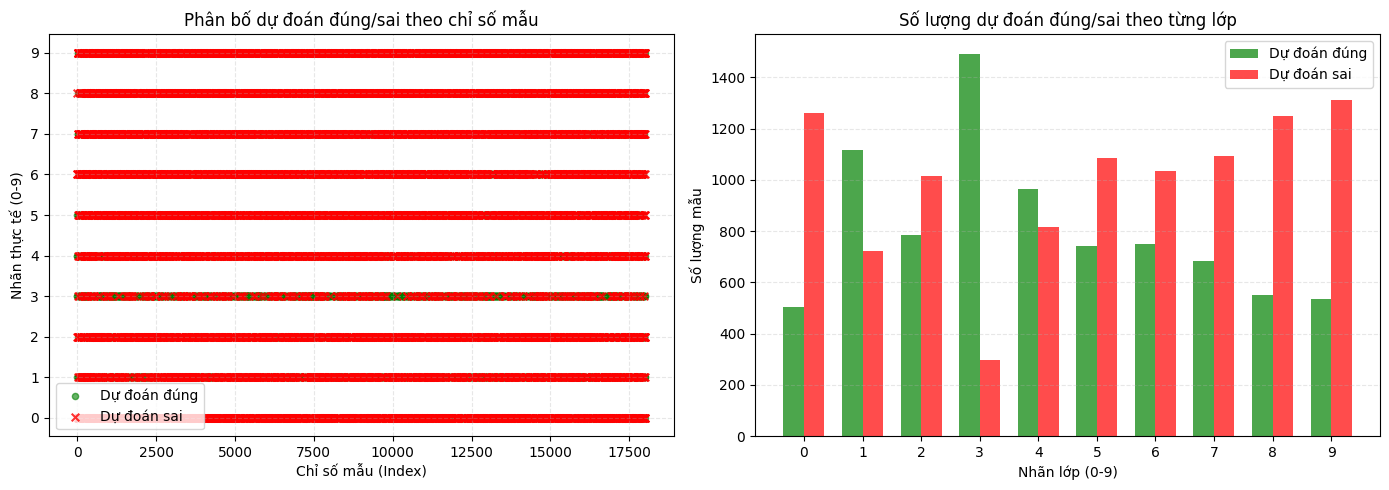

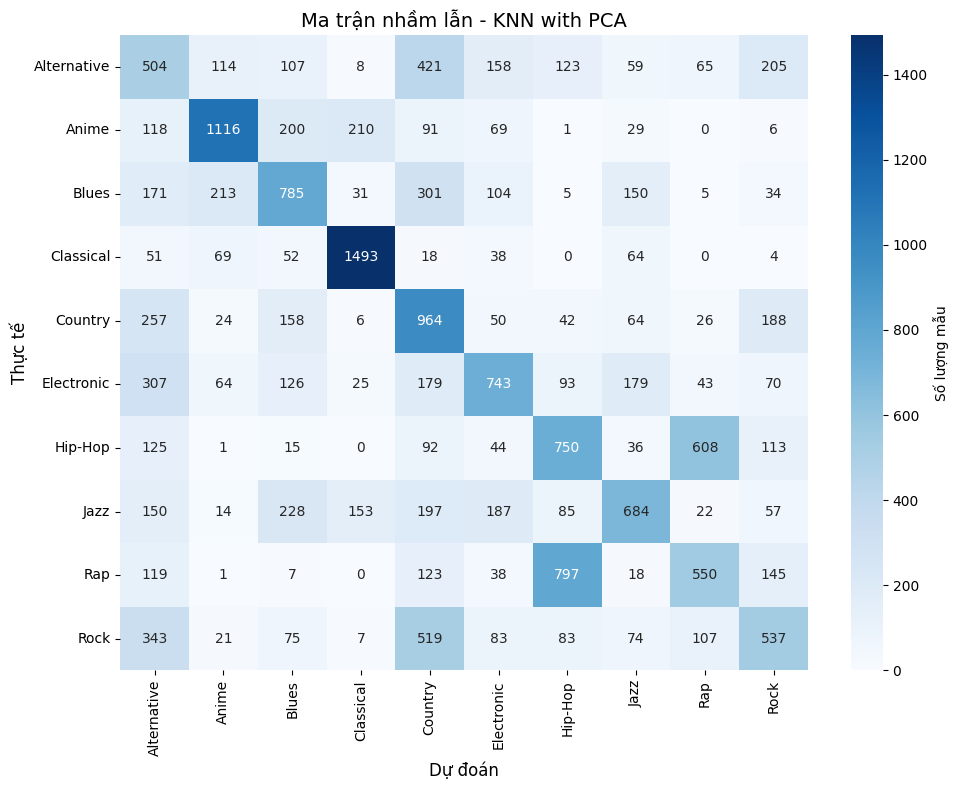

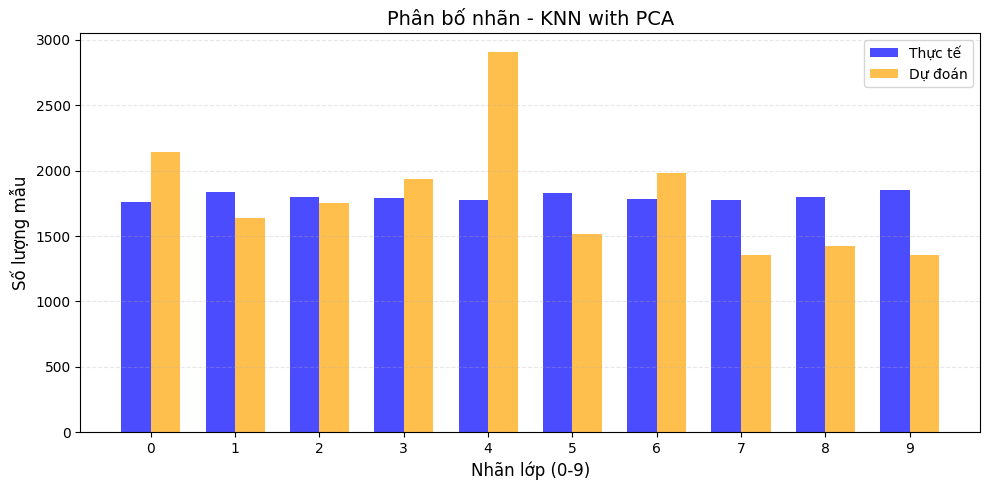

In [62]:
genre_names = le.classes_
knn = KNeighborsClassifier(n_neighbors=13)

helper_and_plot(X_train_3_pca95, X_test_3_pca95, y_train_3, y_test_3,
                model=knn,
                command='KNN with PCA',
                reduce_name='PCA',
                n_components=0.95,
                class_names=genre_names)

## Nhận xét mô hình KNN với giảm chiều PCA

### Đánh giá mô hình có phù hợp không?

**Nhận định: Mô hình KNN, ngay cả khi kết hợp với PCA, chỉ phù hợp ở mức độ nhất định nhưng chưa phải là mô hình tối ưu cho bài toán phân loại 10 thể loại nhạc này.**

### => Mô hình "phù hợp một phần"

- **Mô hình thực hiện rất tốt nhiệm vụ dự đoán Lớp 3 (Classical)**:
  - Precision = 0.77, Recall = 0.83, F1-score = 0.80
  - Đây là lớp được nhận dạng tốt nhất, cho thấy mô hình đã học được pattern đặc trưng rõ ràng của thể loại Classical (nhạc cổ điển có cấu trúc hòa âm, nhịp điệu và nhạc cụ khác biệt rõ rệt)

- **Lớp 1 (Blues) cũng có kết quả khá**:
  - Precision = 0.66, Recall = 0.58, F1-score = 0.62
  - Cho thấy Blues có đặc trưng tương đối dễ phân biệt

- **Chỉ số Accuracy tổng thể đạt 46.39% trên test và 55.84% trên train**, cho thấy mô hình chỉ học được một phần các đặc trưng phân biệt giữa 10 lớp, và có dấu hiệu overfitting nhẹ (train cao hơn test ~9%).

### => Mô hình "chưa tối ưu"

- **Mục tiêu của bài toán**: Phân loại chính xác 10 thể loại nhạc khác nhau một cách công bằng, không thiên vị về một số thể loại cụ thể.

- **Kết quả thực tế**: Mô hình thất bại với đa số các lớp:
  - **Lớp 0 (Alternative)**: Precision = 0.28, Recall = 0.36, F1 = 0.31 → Kém nhất, bị nhầm lẫn nhiều với các thể loại tương đồng (Rock, Rap)
  - **Lớp 8 (Rap)**: Precision = 0.37, Recall = 0.29, F1 = 0.32 → Kém về recall, mô hình bỏ sót nhiều bài Rap
  - **Lớp 2 (Country), 4 (Electronic), 6 (Hip-Hop), 7 (Jazz), 9 (Rock)**: F1-score từ 0.41-0.45 → Dưới mức trung bình
  - **Lớp 5 (Hip-Hop)**: F1 = 0.45, khó phân biệt với Rap do đặc trưng gần nhau

- **Chỉ 2 trong 10 lớp được học tốt** (Classical và Blues), các lớp còn lại đều có hiệu suất kém.

### => Nguyên nhân mô hình hoạt động như vậy

**1. Giảm chiều quá mạnh với PCA (xuống 13 chiều):**
- Dữ liệu âm nhạc ban đầu có nhiều đặc trưng phức tạp (MFCC, spectral features, tempo...)
- PCA chỉ giữ lại 13 chiều → mất quá nhiều thông tin phân biệt, đặc biệt cho các thể loại có đặc trưng tinh tế
- Các lớp có âm thanh tương đồng (Alternative-Rock, Hip-Hop-Rap, Country-Blues) bị chồng lấn cao trong không gian thấp chiều

**2. Đặc trưng một số thể loại không rõ ràng:**
- **Classical** dễ nhận dạng vì: nhạc cụ giao hưởng, không có drum điện tử, cấu trúc hòa âm phức tạp
- **Blues** có đặc trưng guitar đặc trưng, tempo chậm, cấu trúc 12-bar
- **Alternative, Rap, Rock** có nhiều biến thể con, ranh giới mờ nhạt → KNN khó phân biệt trong không gian giảm chiều

**3. KNN nhạy cảm với không gian đặc trưng:**
- KNN dựa vào khoảng cách Euclidean, nhưng sau PCA ý nghĩa vật lý của các chiều mới không rõ ràng
- Không gian 13 chiều không đủ để tạo ra các vùng láng giềng đồng nhất cho 10 lớp
- Mô hình bị "thiên vị" (biased) về các lớp dễ phân biệt nhất (Classical), bỏ qua các lớp khó

**4. Không có cơ chế xử lý sự chồng lấn giữa các lớp:**
- Các cặp thể loại tương tự (Alternative-Rock, Hip-Hop-Rap, Jazz-Blues) cần ranh giới phức tạp hơn
- KNN tuyến tính theo khoảng cách không đủ mạnh để học các ranh giới này

### => Kết luận

**Một mô hình chỉ phù hợp khi nó phân loại tốt tất cả các lớp, không chỉ một vài lớp dễ.**

Mặc dù Accuracy 46.39% cao hơn random guess (~10% cho 10 lớp), nhưng:
- **Macro avg F1 = 0.46** cho thấy hiệu suất trung bình chỉ **46%** trên tất cả các lớp
- **8/10 lớp có F1 < 0.50** → Mô hình thất bại với đa số thể loại nhạc
- **Overfitting nhẹ** (train 55.84% vs test 46.39%) cho thấy mô hình ghi nhớ hơn là học pattern tổng quát